Using device: cuda:2
Tensor keys: ['all_modules']

Adjacency matrix 'all_modules':
Shape: torch.Size([3686, 3686])
Data type: torch.float32
Device: cuda:2
First few values: tensor([ 1.0558e-12,  9.3568e-15,  1.0956e-14,  1.2377e-16, -4.7222e-14],
       device='cuda:2')

Graph initialized with 3686 nodes and 6795141 edges
Sum of self weights: 20954.634765625

Original graph: 3686 nodes and 6795141 edges


Pruning edges: 100%|██████████| 3686/3686 [00:14<00:00, 249.02node/s]


After pruning: 3686 nodes and 1939701 edges


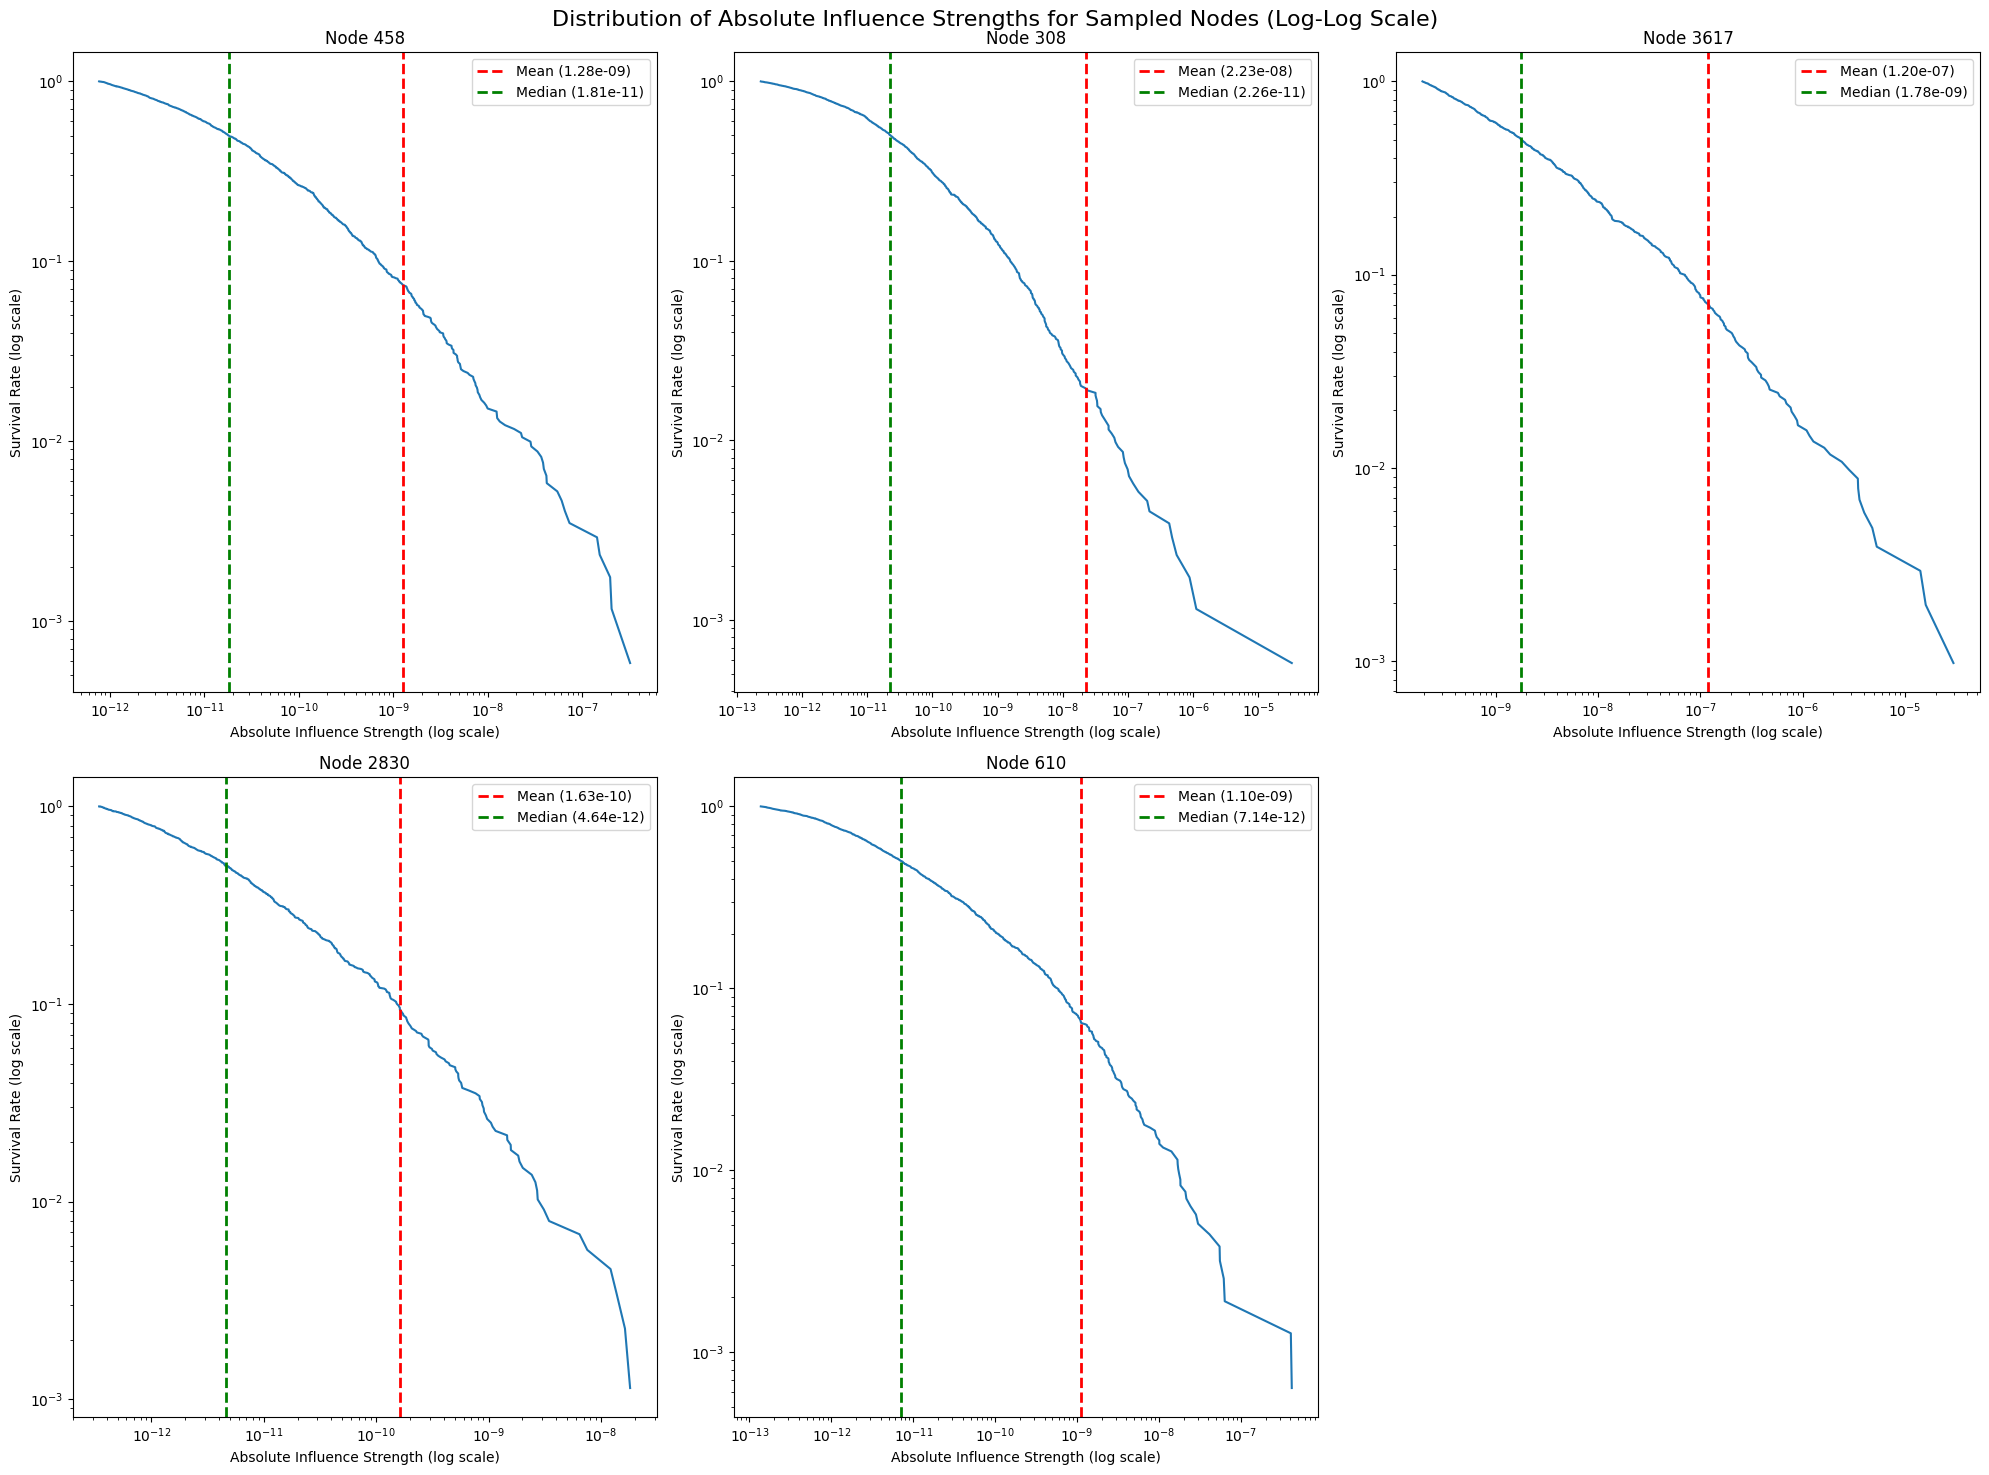


Summary statistics for sampled nodes (absolute values):

Node 458:
  Mean: 1.2760e-09
  Median: 1.8069e-11
  Std Dev: 1.2174e-08
  Min: 7.7206e-13
  Max: 3.1949e-07

Node 308:
  Mean: 2.2297e-08
  Median: 2.2591e-11
  Std Dev: 7.7911e-07
  Min: 2.3347e-13
  Max: 3.2458e-05

Node 3617:
  Mean: 1.2015e-07
  Median: 1.7769e-09
  Std Dev: 1.1957e-06
  Min: 1.9284e-10
  Max: 2.9752e-05

Node 2830:
  Mean: 1.6343e-10
  Median: 4.6356e-12
  Std Dev: 1.1185e-09
  Min: 3.4272e-13
  Max: 1.8165e-08

Node 610:
  Mean: 1.1017e-09
  Median: 7.1353e-12
  Std Dev: 1.5060e-08
  Min: 1.3803e-13
  Max: 4.1605e-07


In [16]:
import torch
import safetensors
from safetensors import safe_open
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Set the GPU device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the file
file_path = "/data/scratch/kaivuh/kronfluencer/influence_results/wikitext/scores_ekfac_pairwise/pairwise_scores.safetensors"
with safe_open(file_path, framework="pt", device="cuda:2") as f:
    print("Tensor keys:", f.keys())
    
    first_key = list(f.keys())[0]
    adjacency_matrix = f.get_tensor(first_key)
    print(f"\nAdjacency matrix '{first_key}':")
    print("Shape:", adjacency_matrix.shape)
    print("Data type:", adjacency_matrix.dtype)
    print("Device:", adjacency_matrix.device)
    print("First few values:", adjacency_matrix.flatten()[:5])

    # Compute the sum of self weights
    self_weights_sum = torch.trace(adjacency_matrix).item()

    # Convert to numpy array and create graph
    adj_np = adjacency_matrix.cpu().numpy()
    G = nx.from_numpy_array(adj_np)

print(f"\nGraph initialized with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Sum of self weights: {self_weights_sum}")

print(f"\nOriginal graph: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Remove edges below median for each node
for node in tqdm(G.nodes(), desc="Pruning edges", unit="node"):
    edges = list(G.edges(node, data=True))
    if edges:
        weights = [d['weight'] for _, _, d in edges]
        median_weight = np.median(weights)
        edges_to_remove = [(u, v) for u, v, d in edges if d['weight'] < median_weight]
        G.remove_edges_from(edges_to_remove)

print(f"After pruning: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

/tmp/ipykernel_1122229/2161449935.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


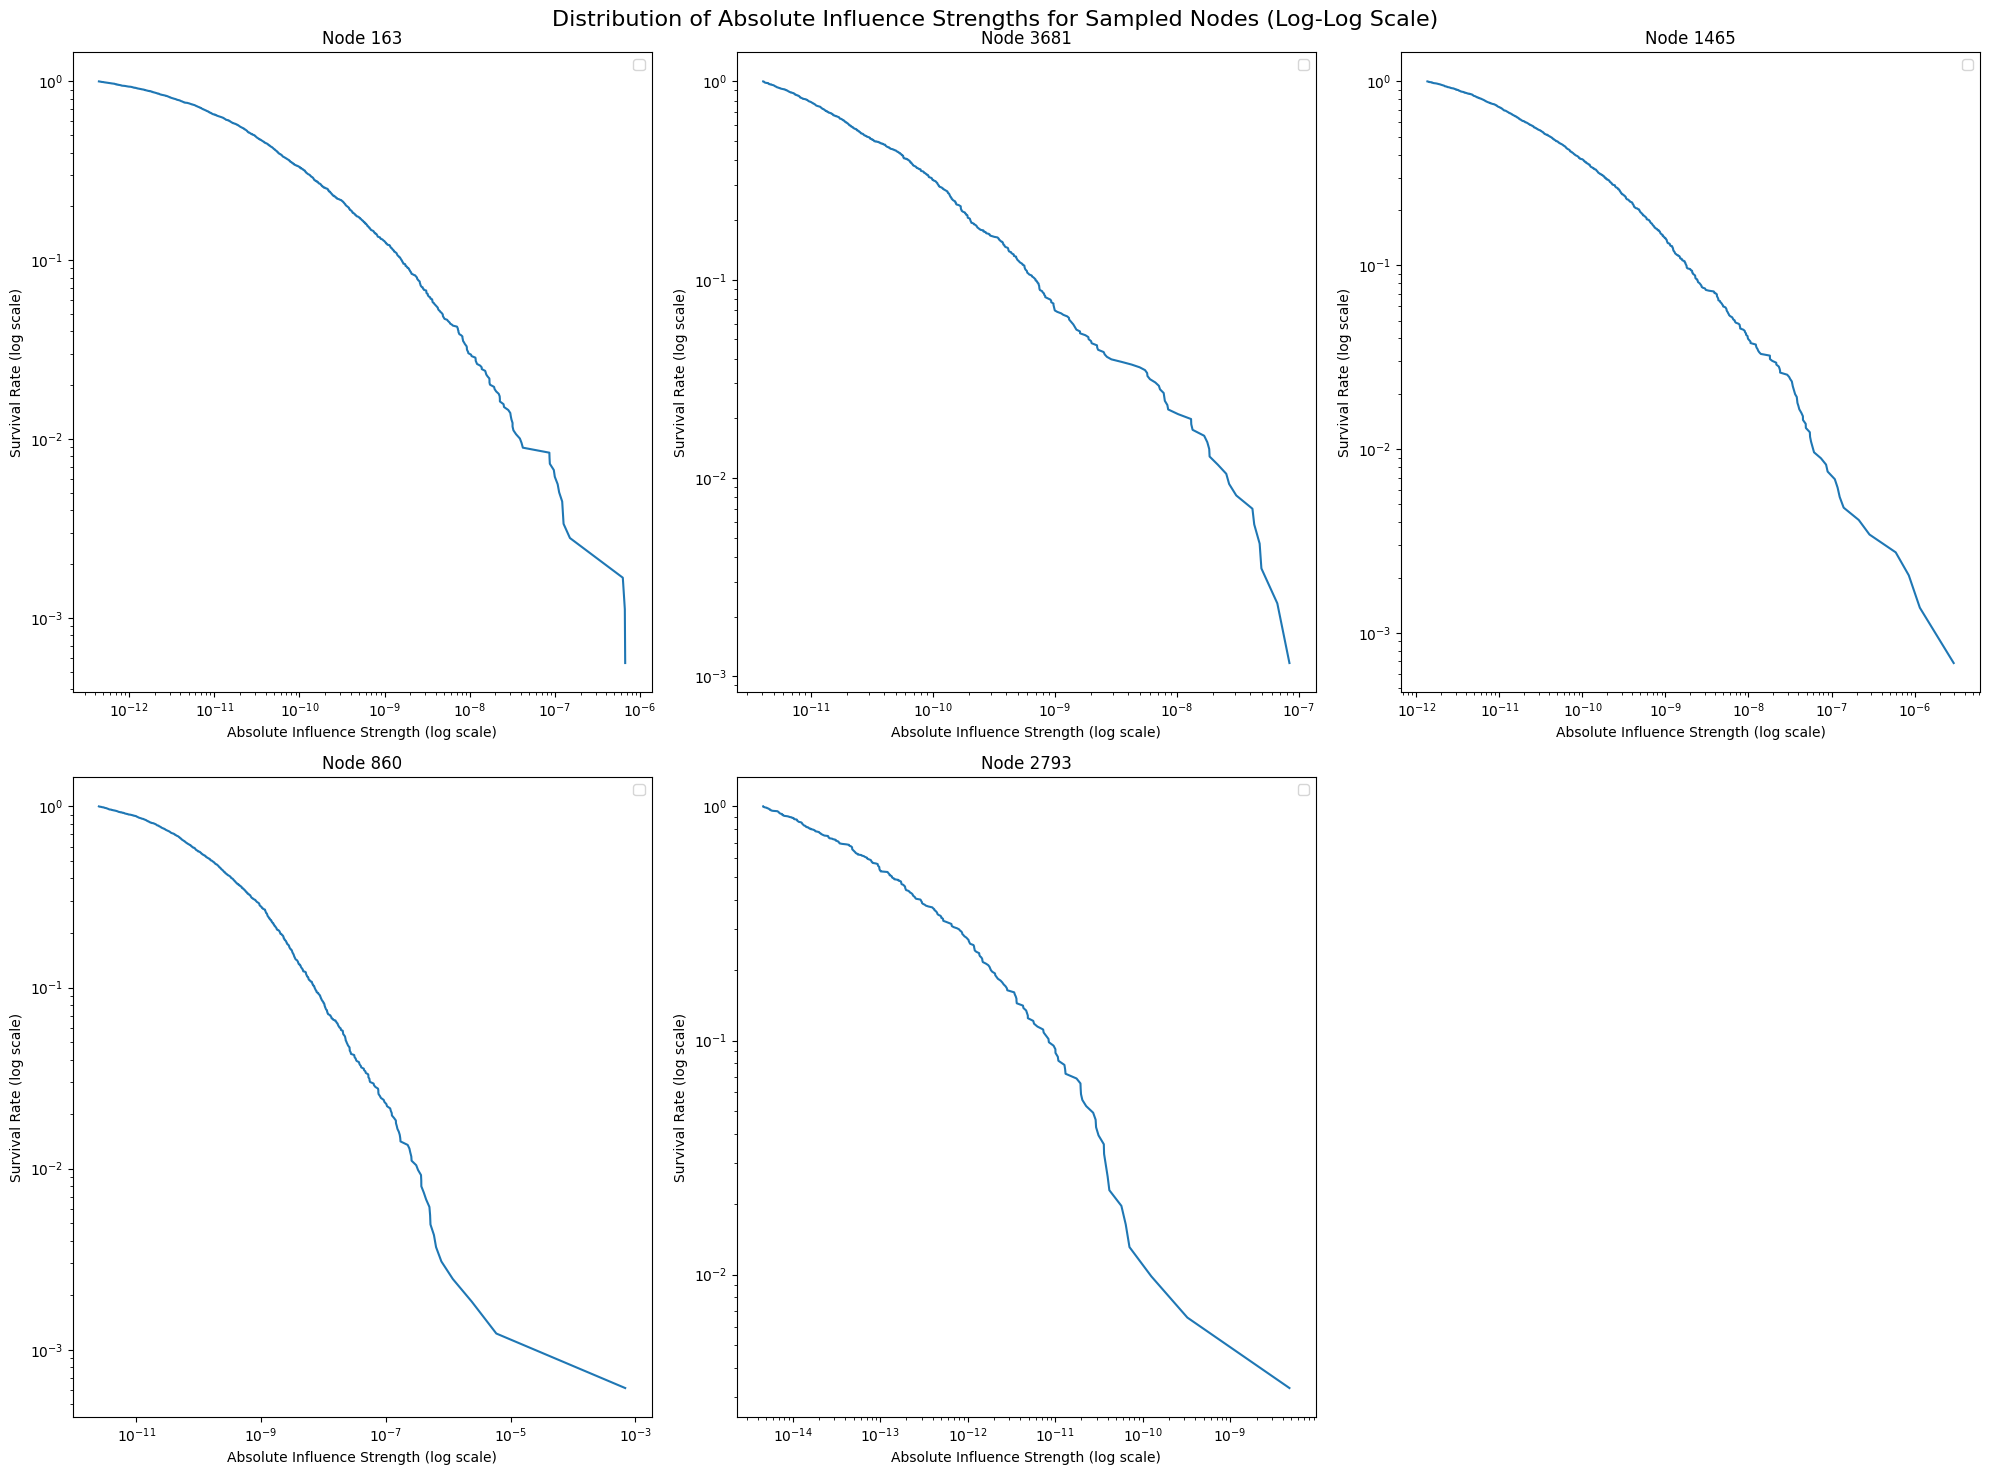


Summary statistics for sampled nodes (absolute values):

Node 163:
  Std Dev: 2.8977e-08
  Min: 4.4214e-13
  Max: 6.6814e-07

Node 3681:
  Std Dev: 5.3727e-09
  Min: 4.0911e-12
  Max: 8.4132e-08

Node 1465:
  Std Dev: 8.8256e-08
  Min: 1.3644e-12
  Max: 2.9542e-06

Node 860:
  Std Dev: 1.7051e-05
  Min: 2.4970e-12
  Max: 6.8819e-04

Node 2793:
  Std Dev: 2.7243e-10
  Min: 4.6048e-15
  Max: 4.7551e-09


In [20]:
# Sample nodes and plot influence distributions
sampled_nodes = random.sample(list(G.nodes()), 5)

fig, axs = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle("Distribution of Absolute Influence Strengths for Sampled Nodes (Log-Log Scale)", fontsize=16)
axs = axs.flatten()

for i, node in enumerate(sampled_nodes):
    weights = np.abs([d['weight'] for _, _, d in G.edges(node, data=True)])
    weights = weights[weights > 0]
    sorted_weights = np.sort(weights)[::-1]
    survival_rate = np.arange(1, len(sorted_weights) + 1) / len(sorted_weights)
    
    axs[i].plot(sorted_weights, survival_rate)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_title(f"Node {node}")
    axs[i].set_xlabel("Absolute Influence Strength (log scale)")
    axs[i].set_ylabel("Survival Rate (log scale)")
    
    mean_weight = np.mean(weights)
    median_weight = np.median(weights)
    # axs[i].axvline(mean_weight, color='r', linestyle='dashed', linewidth=2, label=f'Mean ({mean_weight:.2e})')
    # axs[i].axvline(median_weight, color='g', linestyle='dashed', linewidth=2, label=f'Median ({median_weight:.2e})')
    axs[i].legend()

axs[-1].axis('off')
plt.tight_layout()
plt.show()

print("\nSummary statistics for sampled nodes (absolute values):")
for node in sampled_nodes:
    weights = np.abs([d['weight'] for _, _, d in G.edges(node, data=True)])
    weights = weights[weights > 0]
    print(f"\nNode {node}:")
    # print(f"  Mean: {np.mean(weights):.4e}")
    # print(f"  Median: {np.median(weights):.4e}")
    print(f"  Std Dev: {np.std(weights):.4e}")
    print(f"  Min: {np.min(weights):.4e}")
    print(f"  Max: {np.max(weights):.4e}")

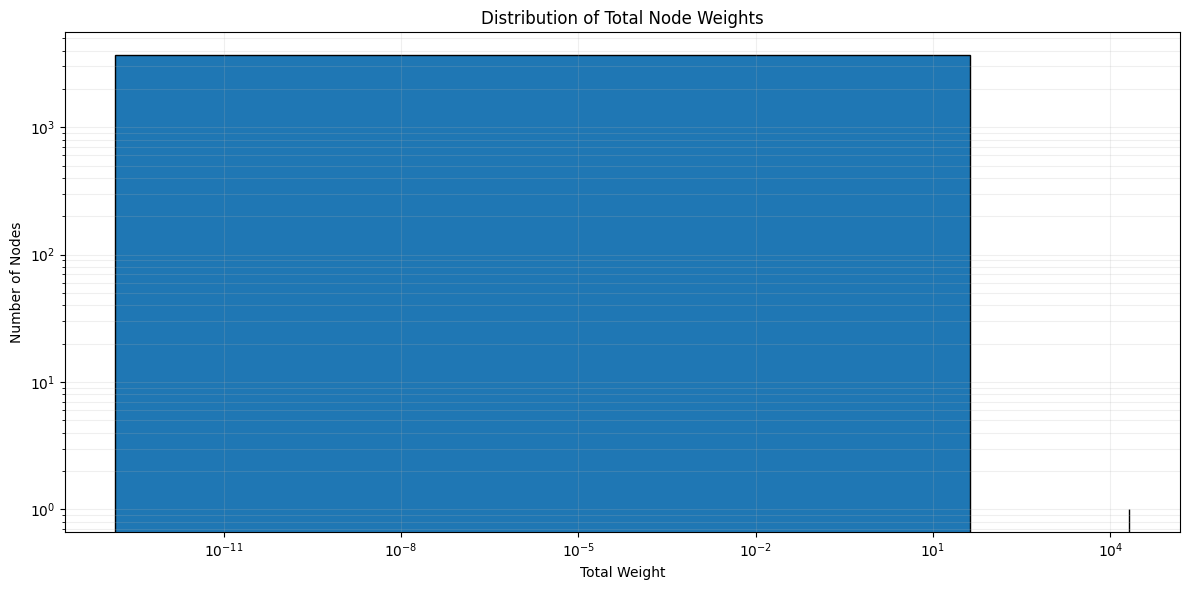


Summary statistics for total node weights:
Mean: 5.692143e+00
Median: 3.573528e-06
Std Dev: 3.452785e+02
Min: 1.467486e-13
Max: 2.096554e+04

Top 10 nodes by total weight:
Node 1046: 2.096554e+04
Node 2994: 4.571663e+00
Node 440: 3.023948e+00
Node 2421: 1.224539e+00
Node 169: 7.098540e-01
Node 891: 5.715501e-01
Node 434: 2.743750e-01
Node 1000: 2.212114e-01
Node 1385: 2.125506e-01
Node 2122: 2.086591e-01


In [29]:
# Compute total weight for each node
total_weights = {}
for node in G.nodes():
    weights = np.abs([d['weight'] for _, _, d in G.edges(node, data=True)])
    total_weights[node] = np.sum(weights)

# Plot the distribution of total weights
plt.figure(figsize=(12, 6))
plt.hist(list(total_weights.values()), bins=500, edgecolor='black')
plt.title("Distribution of Total Node Weights")
plt.xlabel("Total Weight")
plt.ylabel("Number of Nodes")
plt.yscale('log')  # Use log scale for y-axis to better visualize the distribution
plt.xscale('log')  # Use log scale for x-axis as well
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

# Print summary statistics
weights = np.array(list(total_weights.values()))
print("\nSummary statistics for total node weights:")
print(f"Mean: {np.mean(weights):.6e}")
print(f"Median: {np.median(weights):.6e}")
print(f"Std Dev: {np.std(weights):.6e}")
print(f"Min: {np.min(weights):.6e}")
print(f"Max: {np.max(weights):.6e}")

# Identify top 10 nodes by total weight
top_nodes = sorted(total_weights.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by total weight:")
for node, weight in top_nodes:
    print(f"Node {node}: {weight:.6e}")

In [31]:
# Get weights and corresponding indices for node 1046
weights_with_indices = [(abs(d['weight']), target) for target, d in G[1046].items()]
weights_with_indices.sort(reverse=True)  # Sort by weight in descending order

print(f"Top 10 weights for node 1046 with corresponding indices:")
for i, (weight, target) in enumerate(weights_with_indices[:10], 1):
    print(f"{i}. Weight: {weight:.6e}, Target Node: {target}")

# Print total weight for node 1046
total_weight = sum(weight for weight, _ in weights_with_indices)
print(f"\nTotal weight for node 1046: {total_weight:.6e}")

# Print number of connections
print(f"Total number of connections for node 1046: {len(weights_with_indices)}")

Top 10 weights for node 1046 with corresponding indices:
1. Weight: 2.095243e+04, Target Node: 1046
2. Weight: 3.008529e+00, Target Node: 440
3. Weight: 2.775614e+00, Target Node: 2994
4. Weight: 1.219111e+00, Target Node: 2421
5. Weight: 6.871600e-01, Target Node: 169
6. Weight: 5.682671e-01, Target Node: 891
7. Weight: 2.606957e-01, Target Node: 434
8. Weight: 2.161976e-01, Target Node: 1000
9. Weight: 2.073578e-01, Target Node: 2122
10. Weight: 1.989349e-01, Target Node: 1385

Total weight for node 1046: 2.096554e+04
Total number of connections for node 1046: 1597


In [32]:
# Get and sort the largest diagonal values from the original safetensors file
with safe_open(file_path, framework="pt", device="cuda:2") as f:
    first_key = list(f.keys())[0]
    adjacency_matrix = f.get_tensor(first_key)
    diagonal_values = adjacency_matrix.diag()
    
    # Get the top 10 diagonal values and their indices
    top_values, top_indices = torch.topk(diagonal_values, k=10)
    
    print("Top 10 diagonal values with their indices:")
    for i, (value, index) in enumerate(zip(top_values, top_indices), 1):
        print(f"{i}. Index: {index.item()}, Value: {value.item():.6e}")

# Print the diagonal value for node 1046 for comparison
print(f"\nDiagonal value for node 1046: {diagonal_values[1046].item():.6e}")

Top 10 diagonal values with their indices:
1. Index: 1046, Value: 2.095243e+04
2. Index: 2994, Value: 1.740503e+00
3. Index: 1310, Value: 1.546386e-01
4. Index: 2437, Value: 5.478467e-02
5. Index: 1810, Value: 3.987497e-02
6. Index: 759, Value: 3.714890e-02
7. Index: 3505, Value: 2.226183e-02
8. Index: 169, Value: 1.527755e-02
9. Index: 1197, Value: 1.389247e-02
10. Index: 3003, Value: 1.075687e-02

Diagonal value for node 1046: 2.095243e+04
